In [ ]:
# based on the current game state, team strenght, and contextual features, predict how many points a team will score 
# use poisson distribution to model the number of nfl points scored by a team by end of game

# 1. Game State:
    #  minutes into a game (coninous from 0 to 60, and 60+ for overtime
    #  score differential (continuous)
    #  down (discrete)
    #  yards to go (discrete)
    #  yards from endzone (continuous)
    #  quarter (discrete)
    #  time outs remaining offense (discrete)
    #  time outs remaining defense (discrete)

# 2. Team Strength:
    # vegas line of current team winning

# 3. Contextual Features:
    #  curretn team score
    #  home field advantage (binary)
    #  weather (continuous)
    #  injuries (continuous)
    #  penalties (continuous)
    #  turnovers (continuous)
    #  time of possession (continuous)
    #  number of plays (continuous)

# Maybe in the future:
    # difference in elo rating
    # historical quarter back rating normalized by playing time (this one is tricky for rookie qbs with no data)

# problem: hwo do we predict how many points a team will score when they are on deffense?
    # could just model score idfferential, or could model win probability directly

In [74]:
import os

import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl

import nfl_data_py as nfl

plt.style.use('ggplot')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.options.mode.copy_on_write = True

In [2]:
years = range(2000, 2024)
df_pbp = nfl.import_pbp_data(years, downcast=False)
df_pbp.head()

2000 done.
2001 done.
2002 done.
2003 done.
2004 done.
2005 done.
2006 done.
2007 done.
2008 done.
2009 done.
2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.


,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,game_half,quarter_end,drive,sp,qtr,down,goal_to_go,time,yrdln,ydstogo,ydsnet,desc,play_type,yards_gained,shotgun,no_huddle,qb_dropback,qb_kneel,qb_spike,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,field_goal_result,kick_distance,extra_point_result,two_point_conv_result,home_timeouts_remaining,away_timeouts_remaining,timeout,timeout_team,td_team,td_player_name,td_player_id,posteam_timeouts_remaining,defteam_timeouts_remaining,total_home_score,total_away_score,posteam_score,defteam_score,score_differential,posteam_score_post,defteam_score_post,score_differential_post,no_score_prob,opp_fg_prob,opp_safety_prob,opp_td_prob,fg_prob,safety_prob,td_prob,extra_point_prob,two_point_conversion_prob,ep,epa,total_home_epa,total_away_epa,total_home_rush_epa,total_away_rush_epa,total_home_pass_epa,total_away_pass_epa,air_epa,yac_epa,comp_air_epa,comp_yac_epa,total_home_comp_air_epa,total_away_comp_air_epa,total_home_comp_yac_epa,total_away_comp_yac_epa,total_home_raw_air_epa,total_away_raw_air_epa,total_home_raw_yac_epa,total_away_raw_yac_epa,wp,def_wp,home_wp,away_wp,wpa,vegas_wpa,vegas_home_wpa,home_wp_post,away_wp_post,vegas_wp,vegas_home_wp,total_home_rush_wpa,total_away_rush_wpa,total_home_pass_wpa,total_away_pass_wpa,air_wpa,yac_wpa,comp_air_wpa,comp_yac_wpa,total_home_comp_air_wpa,total_away_comp_air_wpa,total_home_comp_yac_wpa,total_away_comp_yac_wpa,total_home_raw_air_wpa,total_away_raw_air_wpa,total_home_raw_yac_wpa,total_away_raw_yac_wpa,punt_blocked,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,third_down_failed,fourth_down_converted,fourth_down_failed,incomplete_pass,touchback,interception,punt_inside_twenty,punt_in_endzone,punt_out_of_bounds,punt_downed,punt_fair_catch,kickoff_inside_twenty,kickoff_in_endzone,kickoff_out_of_bounds,kickoff_downed,kickoff_fair_catch,fumble_forced,fumble_not_forced,fumble_out_of_bounds,solo_tackle,safety,penalty,tackled_for_loss,fumble_lost,own_kickoff_recovery,own_kickoff_recovery_td,qb_hit,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,rush_touchdown,return_touchdown,extra_point_attempt,two_point_attempt,field_goal_attempt,kickoff_attempt,punt_attempt,fumble,complete_pass,assist_tackle,lateral_reception,lateral_rush,lateral_return,lateral_recovery,passer_player_id,passer_player_name,passing_yards,receiver_player_id,receiver_player_name,receiving_yards,rusher_player_id,rusher_player_name,rushing_yards,lateral_receiver_player_id,lateral_receiver_player_name,lateral_receiving_yards,lateral_rusher_player_id,lateral_rusher_player_name,lateral_rushing_yards,lateral_sack_player_id,lateral_sack_player_name,interception_player_id,interception_player_name,lateral_interception_player_id,lateral_interception_player_name,punt_returner_player_id,punt_returner_player_name,lateral_punt_returner_player_id,lateral_punt_returner_player_name,kickoff_returner_player_name,kickoff_returner_player_id,lateral_kickoff_returner_player_id,lateral_kickoff_returner_player_name,punter_player_id,punter_player_name,kicker_player_name,kicker_player_id,own_kickoff_recovery_player_id,own_kickoff_recovery_player_name,blocked_player_id,blocked_player_name,tackle_for_loss_1_player_id,tackle_for_loss_1_player_name,tackle_for_loss_2_player_id,tackle_for_loss_2_player_name,qb_hit_1_player_id,qb_hit_1_player_name,qb_hit_2_player_id,qb_hit_2_player_name,forced_fumble_player_1_team,forced_fumble_player_1_player_id,forced_fumble_player_1_player_name,forced_fumble_player_2_team,forced_fumble_player_2_player_id,forced_fumble_player_2_player_name,solo_tackle_1_team,solo_tackle_2_team,solo_tackle_1_player_id,solo_tackle_2_player_id,solo_tackle_1_player_name,solo_tackle_2_player_name,assist_tackle_1_player_id,assist_tackle_1_player_name,assist_tackle_1_team,assist_tack

In [3]:
df_sched = nfl.import_schedules(years)
df_sched.head()

,game_id,season,game_type,week,gameday,weekday,gametime,away_team,away_score,home_team,home_score,location,result,total,overtime,old_game_id,gsis,nfl_detail_id,pfr,pff,espn,ftn,away_rest,home_rest,away_moneyline,home_moneyline,spread_line,away_spread_odds,home_spread_odds,total_line,under_odds,over_odds,div_game,roof,surface,temp,wind,away_qb_id,home_qb_id,away_qb_name,home_qb_name,away_coach,home_coach,referee,stadium_id,stadium
259,2000_01_SF_ATL,2000,REG,1,2000-09-03,Sunday,13:00,SF,28.0,ATL,36.0,Home,8.0,64.0,0.0,2000090310,998.0,NaN,200009030atl,NaN,200903001.0,NaN,7,7,NaN,NaN,6.5,NaN,NaN,46.5,NaN,NaN,1,dome,astroturf,NaN,NaN,00-0005755,00-0002876,Jeff Garcia,Chris Chandler,Steve Mariucci,Dan Reeves,Walt Coleman,ATL00,Georgia Dome
260,2000_01_JAX_CLE,2000,REG,1,2000-09-03,Sunday,13:00,JAX,27.0,CLE,7.0,Home,-20.0,34.0,0.0,2000090306,994.0,NaN,200009030cle,NaN,200903005.0,NaN,7,7,NaN,NaN,-10.5,NaN,NaN,38.5,NaN,NaN,1,outdoors,grass,78.0,6.0,00-0002110,00-0003535,Mark Brunell,Tim Couch,Tom Coughlin,Chris Palmer,Bernie Kukar,CLE00,Cleveland Browns Stadium
261,2000_01_IND_KC,2000,REG,1,2000-09-03,Sunday,13:00,IND,27.0,KC,14.0,Home,-13.0,41.0,0.0,2000090305,993.0,NaN,200009030kan,NaN,200903012.0,NaN,7,7,NaN,NaN,-3.5,NaN,NaN,44.0,NaN,NaN,0,outdoors,grass,90.0,5.0,00-0010346,00-0006300,Peyton Manning,Elvis Grbac,Jim Mora,Gunther Cunningham,Larry Nemmers,KAN00,Arrowhead Stadium
262,2000_01_CHI_MIN,2000,REG,1,2000-09-03,Sunday,13:00,CHI,27.0,MIN,30.0,Home,3.0,57.0,0.0,2000090303,991.0,NaN,200009030min,NaN,200903016.0,NaN,7,7,NaN,NaN,4.5,NaN,NaN,46.5,NaN,NaN,1,dome,astroturf,NaN,NaN,00-0011044,00-0003739,Cade McNown,Daunte Culpepper,Dick Jauron,Dennis Green,Ed Hochuli,MIN00,Hubert H. Humphrey Metrodome
263,2000_01_TB_NE,2000,REG,1,2000-09-03,Sunday,13:00,TB,21.0,NE,16.0,Home,-5.0,37.0,0.0,2000090312,1000.0,NaN,200009030nwe,NaN,200903017.0,NaN,7,7,NaN,NaN,-3.0,NaN,NaN,36.0,NaN,NaN,0,outdoors,grass,71.0,5.0,00-0009266,00-0001361,Shaun King,Drew Bledsoe,Tony Dungy,Bill Belichick,Jeff Triplette,BOS99,Foxboro Stadium


In [46]:
cols = ['game_id','season','season_type','qtr','quarter_seconds_remaining','posteam','score_differential']
        
['','','','','','','',
'','','','','','','','',
'','','','','','','','',
'','','','','','','','',
'','','']

df_wp = df_pbp.query('~play_type.isnull()')[cols]


# in 2017, the nfl changed regular season overtime length from 15 minutes to 10 minutes 
df_wp['time'] = np.where((df_wp['season_type'] == 'REG') & (df_wp['season'] >= 2017), 
                         (600 * (df_wp['qtr'] - 4)) + (900 * 4) - df_wp['quarter_seconds_remaining'], 
                         900 * df_wp['qtr'] - df_wp['quarter_seconds_remaining'])

df_wp = df_wp.merge(df_sched[['game_id','away_score','home_team','home_score','location']], on='game_id', how='left')

df_wp['end_score_diff'] = np.where(df_wp['posteam'] == df_wp['home_team'], df_wp['home_score'] - df_wp['away_score'], df_wp['away_score'] - df_wp['home_score'])
df_wp = df_wp.drop(columns=['home_team','home_score','away_score','posteam'])
df_wp['won_game'] = np.where(df_wp['end_score_diff'] > 0, 1, 0)

In [47]:
df_wp = df_wp.dropna().drop_duplicates(ignore_index=True)

In [75]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

seed = 123

X = df_wp[['time','score_differential']]
y = df_wp['won_game']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

rf = RandomForestClassifier(n_estimators=100, random_state=seed, n_jobs=-1)
rf.fit(X_train, y_train)

print("*** TRAIN SET ***")
y_pred = rf.predict(X_train)
y_pred_proba = rf.predict_proba(X_train)

print(classification_report(y_train, y_pred))
print(confusion_matrix(y_train, y_pred))

print("\n*** TEST SET ***")
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

*** TRAIN SET ***
              precision    recall  f1-score   support

           0       0.76      0.73      0.74    398048
           1       0.75      0.77      0.76    408652

    accuracy                           0.75    806700
   macro avg       0.75      0.75      0.75    806700
weighted avg       0.75      0.75      0.75    806700

[[292022 106026]
 [ 94380 314272]]

*** TEST SET ***
              precision    recall  f1-score   support

           0       0.70      0.68      0.69     99653
           1       0.69      0.72      0.70    102023

    accuracy                           0.70    201676
   macro avg       0.70      0.70      0.70    201676
weighted avg       0.70      0.70      0.70    201676

[[67424 32229]
 [29065 72958]]


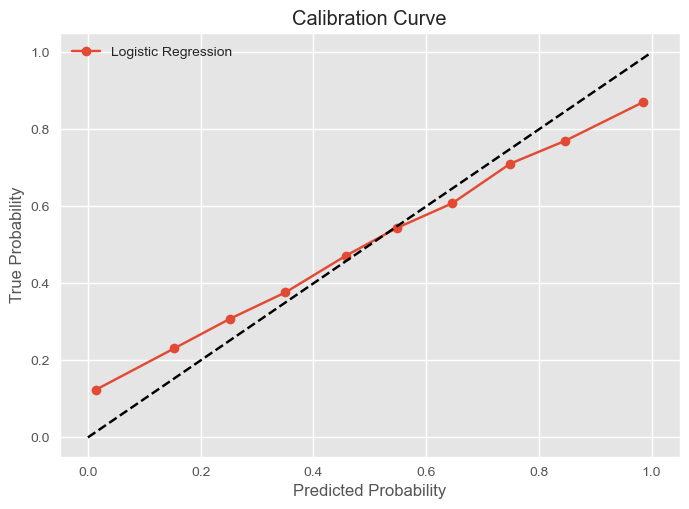

In [76]:
# create a calibration curve: bin the predicted probabilities and compare to the actual outcomes, plot on a graph

from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, y_pred_proba[:,1], n_bins=10)

plt.plot(prob_pred, prob_true, marker='o', label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Curve')
plt.legend()
plt.show()

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

X = df_wp[['time','score_differential']]
y = df_wp['won_game']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Create logistic regression object
lr = LogisticRegression(random_state=42)

# Train the model
lr.fit(X_train, y_train)

print("*** TRAIN SET ***")
y_pred = lr.predict(X_train)
y_pred_proba = lr.predict_proba(X_train)

print(classification_report(y_train, y_pred))
print(confusion_matrix(y_train, y_pred))

print("\n*** TEST SET ***")
y_pred = lr.predict(X_test)
y_pred_proba = lr.predict_proba(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


*** TRAIN SET ***
              precision    recall  f1-score   support

           0       0.75      0.66      0.70    398048
           1       0.71      0.78      0.74    408652

    accuracy                           0.72    806700
   macro avg       0.73      0.72      0.72    806700
weighted avg       0.73      0.72      0.72    806700

[[264691 133357]
 [ 88899 319753]]

*** TEST SET ***
              precision    recall  f1-score   support

           0       0.75      0.66      0.70     99653
           1       0.71      0.78      0.74    102023

    accuracy                           0.72    201676
   macro avg       0.73      0.72      0.72    201676
weighted avg       0.73      0.72      0.72    201676

[[66243 33410]
 [22138 79885]]


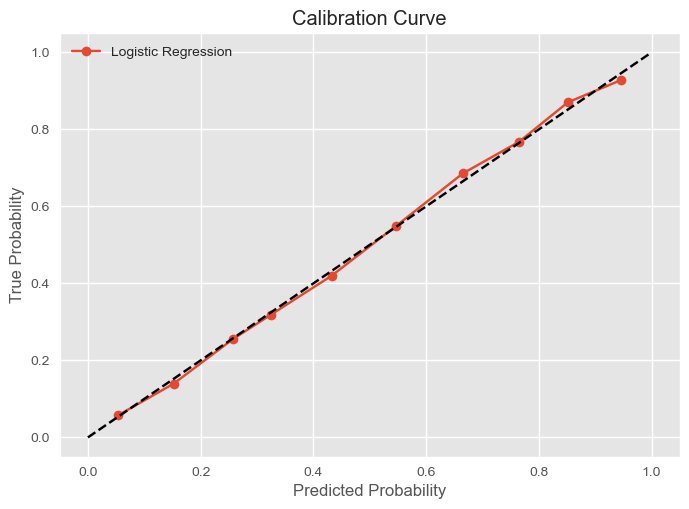

In [73]:
# create a calibration curve: bin the predicted probabilities and compare to the actual outcomes, plot on a graph

from sklearn.calibration import calibration_curve

plt.style.use('ggplot')


prob_true, prob_pred = calibration_curve(y_test, y_pred_proba[:,1], n_bins=10)

plt.plot(prob_pred, prob_true, marker='o', label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Curve')
plt.legend()
plt.show()

In [ ]:
df_wp.head()

,game_id,season,season_type,qtr,quarter_seconds_remaining,score_differential,time,location,end_score_diff,won_game
0,2000_01_ARI_NYG,2000,REG,1.0,900.0,0.0,0.0,Home,-5.0,0
1,2000_01_ARI_NYG,2000,REG,1.0,844.0,0.0,56.0,Home,-5.0,0
2,2000_01_ARI_NYG,2000,REG,1.0,837.0,0.0,63.0,Home,-5.0,0
3,2000_01_ARI_NYG,2000,REG,1.0,832.0,0.0,68.0,Home,-5.0,0
4,2000_01_ARI_NYG,2000,REG,1.0,820.0,0.0,80.0,Home,5.0,1


In [105]:
# predict end_game_score_diff usin pymc and poisson distribution, then generate win probability by randomly sampling from the posterior disribuotin
os.environ['OMP_NUM_THREADS'] = str(n_cores)

with pm.Model() as model:
    # Priors
    b0 = pm.Normal('intercept', mu=0, sigma=10)
    b1 = pm.Normal('time', mu=0, sigma=10)
    b2 = pm.Normal('score_diff', mu=0, sigma=10)
    
    x_time = pm.Data('x_time', X_train['time'].values)
    x_score_diff = pm.Data('x_score_diff', X_train['score_differential'].values)
    
    # Linear model
    theta = (
        b0 + 
        b1 * x_time + 
        b2 * x_score_diff
    )
    
    # Likelihood (using a normal distribution for continuous outcomes)
    y = pm.Normal('y', mu=theta, sigma=10, observed=y_train.values)
    
    # Perform ADVI to approximate the posterior
    # Mean-field ADVI
    mean_field_approx = pm.fit(n=10000, method='advi')  # Number of iterations for convergence
    
    # Alternatively, for Full-Rank ADVI, use:
    # full_rank_approx = pm.fit(n=10000, method='fullrank_advi')
    
    # Obtain posterior samples from the approximation
    advi_trace = mean_field_approx.sample(draws=5000)  # Number of samples to draw from the posterior
    

# generate win probability by randomly sampling from the posterior disribuotin 10000 times, if the draw is positive, they won, if negative, they lost, then 
# calculate the win probability by dividing the number of wins by the total number of draws
# df_wp['win_prob'] = np.nan

# for i in range(10000):
#     df_wp['win_prob'] = df_wp['win_prob'] + np.where(np.random.poisson(trace['intercept'] + trace['time'] + trace['score_diff'] + trace['home_adv']) > 0, 1, 0)

# df_wp['win_prob'] = df_wp['win_prob'] / 10000

Output()

Finished [100%]: Average Loss = 3.4333e+08


In [121]:
advi_trace

Inference data with groups:
	> posterior
	> observed_data
	> constant_data

In [124]:
import arviz as az

az.plot_posterior(advi_trace['theta'])


KeyError: 'theta'

In [125]:
# Update model with test data
with model:
    pm.set_data({
        'x_time': X_test['time'].values,
        'x_score_diff': X_test['score_differential'].values
    })

    # Sample from the posterior predictive distribution
    posterior_predictive = pm.sample_posterior_predictive(advi_trace, random_seed=seed, var_names=['y'], samples=1000)

# Extract the predicted end-game score differentials
predicted_diff = posterior_predictive['y'] 

# Calculate win probabilities
# Assuming a win is predicted if the score differential is positive
win_probabilities = np.mean(predicted_diff > 0, axis=0)

# Output the win probabilities for the test set
print("Predicted Win Probabilities for Test Set:")
print(win_probabilities)

TypeError: sample_posterior_predictive() got an unexpected keyword argument 'samples'

In [118]:
y_train.shape

(806700,)

In [98]:
np.where((advi_trace['posterior']['intercept'] + advi_trace['posterior']['time'] + advi_trace['posterior']['score_diff'])> 0, 1, 0).mean()

0.6588

In [99]:
advi_trace

Inference data with groups:
	> posterior
	> observed_data